<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Disaster Risk Monitoring Using Satellite Imagery #

## 03 - Deploying a Model for Inference ##
In this notebook, we will take our previously segmentation model and deploy it on Triton Inference Server. TensorRT is a highly optimized package that takes trained models and optimizes them for inference. We'll see how to create model directory structures and configuration files within Triton Inference Server and how to send inference requests to the models deployed within Triton Inference Server.

**Table of Contents**
<br>
This notebook covers the below sections: 
1. [Introduction to Triton Inference Server](#s3-1)
    * [Server](#s3-1.1)
    * [Client](#s3-1.2)
2. [Model Repository](#s3-2)
    * [Exercise #1 - Model Configuration](#s3-e1)
3. [Run Inference on Triton Inference Server](#s3-3)
    * [Server Health Status](#s3-3.1)
    * [Exercise #2 - Pre-process Inputs](#s3-e2)
    * [Send Request to Server](#s3-3.2)
    * [Visualize Results](#s3-3.3)
4. [Conclusion](#s3-4)

<a name='s3-1'></a>
## Introduction to Triton Inference Server ##
NVIDIA [Triton Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server) simplifies the deployment of AI models at scale in production. Triton is an open-source, inference-serving software that lets teams deploy trained AI models from any framework, from local storage, or from Google Cloud Platform or Azure on any GPU or CPU-based infrastructure, cloud, data center, or edge. The below figure shows the Triton Inference Server high-level architecture. The model repository is a _file-system based repository_ of the models that Triton will make available for inferencing. Inference requests arrive at the server via either [HTTP/REST](https://en.wikipedia.org/wiki/Representational_state_transfer), [gRPC](https://en.wikipedia.org/wiki/GRPC), or by the C API and are then routed to the appropriate per-model scheduler. Triton implements multiple scheduling and batching algorithms that can be configured on a model-by-model basis. Each model's scheduler optionally performs batching of inference requests and then passes the requests to the backend corresponding to the model type. The backend performs inferencing using the inputs provided in the batched requests to produce the requested outputs. The outputs are then returned.
<p><img src='images/triton_server_architecture.png' width='720'/></p>

<a name='s3-1.1'></a>
### Server ###
Setting up the Triton Inference Server requires software for the server and the client. One can get started with Triton Inference Server by pulling the [container](https://ngc.nvidia.com/catalog/containers/nvidia:tritonserver) from the NVIDIA NGC catalog. In this lab, we already have Triton Inference Server instance running. The code to run a Triton Server Instance is shown below. More details can be found in the QuickStart and build instructions:
* [QuickStart Documentation](https://github.com/triton-inference-server/server/blob/r20.12/docs/quickstart.md)
* [Build Documentation](https://github.com/triton-inference-server/server/blob/r20.12/docs/build.md)

```
docker run \
  --gpus=1 \
  --ipc=host --rm \
  --shm-size=1g \
  --ulimit memlock=-1 \
  --ulimit stack=67108864 \
  -p 8000:8000 -p 8001:8001 -p 8002:8002 \
  -v /models:/models \
  nvcr.io/nvidia/tritonserver:20.12-py3 \
  tritonserver \
  --model-repository=/models \
  --exit-on-error=false \
  --model-control-mode=poll \
  --repository-poll-secs 30
```

<a name='s3-1.2'></a>
### Client ###
We've also installed the Triton Inference Server Client libraries to provide APIs that make it easy to communicate with Triton from your C++ or Python application. Using these libraries, you can send either HTTP/REST or gRPC requests to Triton to access all its capabilities: inferencing, status and health, statistics and metrics, model repository management, etc. These libraries also support using system and CUDA shared memory for passing inputs to and receiving outputs from Triton. The easiest way to get the Python client library is to use `pip` to install the `tritonclient` module, as detailed below. For more details on how to download or build the Triton Inference Server Client libraries, you can find the documentation [here](https://github.com/triton-inference-server/server/blob/r20.12/docs/client_libraries.md), as well as examples that show the use of both the C++ and Python libraries.

```
pip install nvidia-pyindex
pip install tritonclient[all]
```

<a name='s3-2'></a>
## Model Repository ##
Triton Inference Server serves models within a model repository. When you first run Triton Inference Server, you'll specify the model repository where the models reside:

```
tritonserver --model-repository=/models
```

Each model resides in its own model subdirectory within the model repository - i.e., each directory within `/models` represents a unique model. For example, in this notebook we'll be deploying our `flood_segmentation_model`. All models typically follow a similar directory structure. Within each of these directories, we'll create a configuration file `config.pbtxt` that details information about the model - e.g. _batch size_, _input shapes_, _deployment backend_ (PyTorch, ONNX, TensorFlow, TensorRT, etc.) and more. Additionally, we can create one or more versions of our model. Each version lives under a subdirectory name with the respective version number, starting with `1`. It is within this subdirectory where our model files reside. 

```
root@server:/models$ tree
.
├── flood_segmentation_model
│   ├── 1
│   │   └── model.plan
│   └── config.pbtxt
│

```

We can also add a file representing the names of the outputs. We have omitted this step in this notebook for the sake of brevity. For more details on how to work with model repositories and model directory structures in Triton Inference Server, please see the [documentation](https://github.com/triton-inference-server/server/blob/r20.12/docs/model_repository.md). Below, we'll create the model directory structure for our flood detection segmentation model.

In [1]:
# DO NOT CHANGE THIS CELL
# set environment variables
import os

%set_env LOCAL_PROJECT_DIR=/dli/task/tao_project
%set_env LOCAL_DATA_DIR=/dli/task/data

os.environ["LOCAL_EXPERIMENT_DIR"]=os.path.join(os.getenv("LOCAL_PROJECT_DIR"), "unet")

env: LOCAL_PROJECT_DIR=/dli/task/tao_project
env: LOCAL_DATA_DIR=/dli/task/data


In [2]:
# DO NOT CHANGE THIS CELL
# create directory for model
!mkdir -p models/flood_segmentation_model/1

# copy resnet18.engine from previous notebook to the model repository
!cp $LOCAL_EXPERIMENT_DIR/export/resnet18.engine models/flood_segmentation_model/1/model.plan

<a name='s3-e1'></a>
### Exercise #1 - Model Configuration ###
With our model directory set up, we now turn our attention to creating the configuration file for our model. A minimal model configuration must specify the name of the model, the `platform` and/or backend properties, the `max_batch_size` property, and the `input` and `output` tensors of the model (name, data type, and shape). We can get the `output` tensor name from the `nvinfer_config.txt` [file](tao_project/unet/resnet18/weights/nvinfer_config.txt) we generated before under `output-blob-names`. For more details on how to create model configuration files within Triton Inference Server, please see the [documentation](https://github.com/triton-inference-server/server/blob/r20.12/docs/model_configuration.md). 

**Instructions**:<br>
* Modify the `<FIXME>`s only and execute the cell to create the `config.pbtxt` file for the segmentation_model. 

In [3]:
# DO NOT CHANGE THIS CELL
configuration = """
name: "flood_segmentation_model"
platform: "tensorrt_plan"
max_batch_size: 1
input: [
 {
    name: "input_1"
    data_type: TYPE_FP32
    format: FORMAT_NCHW
    dims: [ 3, 512, 512]
  }
]
output: {
    name: "softmax_1"
    data_type: TYPE_FP32
    dims: [ 512, 512, 2 ]
  }
"""

with open('models/flood_segmentation_model/config.pbtxt', 'w') as file:
    file.write(configuration)

Click ... to show **solution**. 

<a name='s3-3'></a>
## Run Inference on Triton Inference Server ##
With our model directory structures created, models defined and exported, and configuration files created, we will now wait for Triton Inference Server to load our models. We have set up this lab to use Triton Inference Server in **polling** mode. This means that Triton Inference Server will continuously poll for modifications to our models or for newly created models - once every 30 seconds. Please run the cell below to allow time for Triton Inference Server to poll for new models/modifications before proceeding. Due to the asynchronous nature of this step, we have added 15 seconds to be safe.

<a name='s3-3.1'></a>
### Server Health Status ###

In [4]:
# DO NOT CHANGE THIS CELL
!sleep 45

At this point, our models should be deployed and ready to use! To confirm Triton Inference Server is up and running, we can send a `curl` request to the below URL. The HTTP request returns status _200_ if Triton is ready and _non-200_ if it is not ready. We can also send a `curl` request to our model endpoints to confirm our models are deployed and ready to use. Additionally, we will also see information about our models such:
* The name of our model,
* The versions available for our model,
* The backend platform (e.g., tensort_rt, pytorch_libtorch, onnxruntime_onnx), 
* The inputs and outputs, with their respective names, data types, and shapes.

In [5]:
# DO NOT CHANGE THIS CELL
!curl -v triton:8000/v2/health/ready

*   Trying 172.18.0.3:8000...
* TCP_NODELAY set
* Connected to triton (172.18.0.3) port 8000 (#0)
> GET /v2/health/ready HTTP/1.1
> Host: triton:8000
> User-Agent: curl/7.68.0
> Accept: */*
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< Content-Length: 0
< Content-Type: text/plain
< 
* Connection #0 to host triton left intact


In [6]:
# DO NOT CHANGE THIS CELL
!curl -v triton:8000/v2/models/flood_segmentation_model

*   Trying 172.18.0.3:8000...
* TCP_NODELAY set
* Connected to triton (172.18.0.3) port 8000 (#0)
> GET /v2/models/flood_segmentation_model HTTP/1.1
> Host: triton:8000
> User-Agent: curl/7.68.0
> Accept: */*
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< Content-Type: application/json
< Content-Length: 224
< 
* Connection #0 to host triton left intact
{"name":"flood_segmentation_model","versions":["1"],"platform":"tensorrt_plan","inputs":[{"name":"input_1","datatype":"FP32","shape":[-1,3,512,512]}],"outputs":[{"name":"softmax_1","datatype":"FP32","shape":[-1,512,512,2]}]}

<a name='s3-e2'></a>
### Exercise #2 - Pre-process Inputs ###
Triton itself does not do anything with your input tensors, it simply feeds them to the model. Same for outputs. Ensuring that the preprocessing operations used for inference are defined identically as they were when the model was trained is key to achieving high accuracy. In our case, we need to perform normalization and mean subtraction to produce the final float planar data to the TensorRT engine for inferencing. We can get the `offsets` and `net-scale-factor` from the `nvinfer_config.txt` [file](tao_project/unet/resnet18/weights/nvinfer_config.txt). The pre-processing function is:

<b>y = net scale factor * (x-mean)</b>

where: 
* x is the input pixel value. It is an int8 with range [0,255].
* mean is the corresponding mean value, read either from the mean file or as offsets[c], where c is the channel to which the input pixel belongs, and offsets is the array specified in the configuration file. It is a float.
* net-scale-factor is the pixel scaling factor specified in the configuration file. It is a float.
* y is the corresponding output pixel value. It is a float.

**Instructions**:<br>
* Execute the cell to import dependencies. 
* Modify the `<FIXME>`s only and execute the cell below to pre-process the input image. 

In [14]:
# DO NOT CHANGE THIS CELL
# import dependencies
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import warnings
import random
import warnings
warnings.filterwarnings("ignore")

In [15]:
# choose random image
random_image_file=random.sample(os.listdir(os.path.join(os.getenv('LOCAL_DATA_DIR'), 'images', 'all_images')), 1)

# pre-process image
image=Image.open(os.path.join(os.getenv('LOCAL_DATA_DIR'), 'images', 'all_images', random_image_file[0]))
image_ary=np.asarray(image)
image_ary=image_ary.astype(np.float32)

image_ary=(image_ary-127.5)*0.00784313725490196
image_ary=np.transpose(image_ary, [2, 0, 1])
display(image_ary.shape)

image_ary=np.expand_dims(image_ary, axis=0)
display(image_ary.shape)

(3, 512, 512)

(1, 3, 512, 512)

Click ... to show **solution**. 

<a name='s3-3.2'></a>
### Send Inference Request to Server ###
With our models deployed, it is now time to send inference requests to our models. First, we'll load the `tritonclient.http` module. We will also define the input and output names of our model, the name of our model, the URL where our models are deployed with Triton Inference Server (in this case the host `triton:8000`), and our model version.

In [16]:
# DO NOT CHANGE THIS CELL
import tritonclient.http as tritonhttpclient

# set parameters
VERBOSE=False
input_name='input_1'
input_shape=(1, 3, 512, 512)
input_dtype='FP32'
output_name='softmax_1'
model_name='flood_segmentation_model'
url='triton:8000'
model_version='1'

We'll instantiate our client `triton_client` using the `tritonhttpclient.InferenceServerClient` class access the model metadata with the `get_model_metadata()` method as well as get our model configuration with the `get_model_config()` method.

In [17]:
# DO NOT CHANGE THIS CELL
triton_client=tritonhttpclient.InferenceServerClient(url=url, verbose=VERBOSE)
model_metadata=triton_client.get_model_metadata(model_name=model_name, model_version=model_version)
model_config=triton_client.get_model_config(model_name=model_name, model_version=model_version)

We'll instantiate a placeholder for our input data using the input name, shape, and data type expected. We'll set the data of the input to be the NumPy array representation of our image. We'll also instantiate a placeholder for our output data using just the output name. Lastly, we'll submit our input to the Triton Inference Server using the `triton_client.infer()` method, specifying our model name, model version, inputs, and outputs and convert our result to a NumPy array.

In [18]:
# DO NOT CHANGE THIS CELL
inference_input=tritonhttpclient.InferInput(input_name, input_shape, input_dtype)
inference_input.set_data_from_numpy(image_ary)

output=tritonhttpclient.InferRequestedOutput(output_name)
response=triton_client.infer(model_name, 
                             model_version=model_version, 
                             inputs=[inference_input], 
                             outputs=[output])
logits=response.as_numpy(output_name)
logits=np.asarray(logits, dtype=np.float32)
print(logits.shape)

(1, 512, 512, 2)


And that's all there is to it! We can identify the largest logit value per pixel and confirm that our model correctly inferred the presence of flood. 

<a name='s3-3.3'></a>
### Visualize Results ###

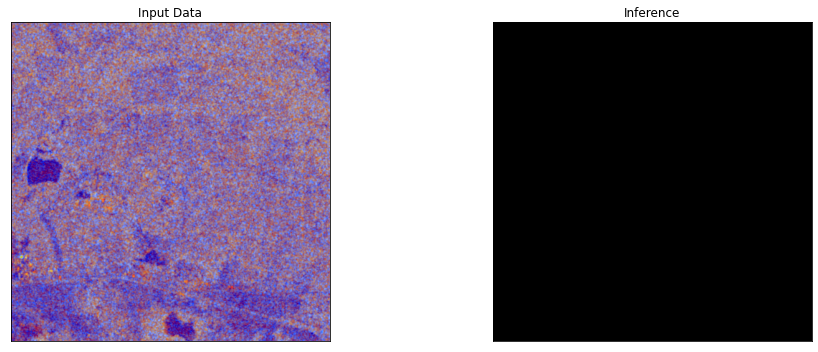

In [19]:
# DO NOT CHANGE THIS CELL
# visualize results
fig, ax_arr=plt.subplots(1, 2, figsize=[15, 5], sharex=True, sharey=True)
ax_arr[0].set_title('Input Data')
ax_arr[1].set_title('Inference')
ax_arr[0].set_xticks([])
ax_arr[0].set_yticks([])

ax_arr[0].imshow(image)
ax_arr[1].imshow(np.argmax(logits[0], axis=2)*255, cmap='gray')

fig.tight_layout()
plt.show()

Recall that we used a random input image for demonstration. In case you don't get an image that shows presence of flood, please feel free to re-run the inference starting from [Exercise #2](#s3-e2). 

<a name='s3-4'></a>
## Conclusion ##
Once deployed, the Triton Inference Server can be connected to front-end applications such as those that power https://www.balcony.io/, which provides an emergency management platform that has the ability to send messages to personal devices. In terms of making the model better, improving on metrics like Intersect-Over-Union (IoU) translates to accurate flood modeling, and coupled with a time-optimized solution aids in real-time disaster response and eventual climate action. 

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>